In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

In [2]:
ARBITRAGE_PATH = 'D:/School/BlockchainCrawler/arbitrum_cache/' + 'receiptsCache_ARBITRUM_ARBITRAGE.json'
REGULAR_PATH = 'D:/School/BlockchainCrawler/arbitrum_cache/' + 'receiptsCache_ARBITRUM_NON_ARBITRAGE.json'

In [3]:
def process_json(path, label):
    with open(path) as file:
        transactions = json.load(file)

        senders, receivers, fees, rounded_fees, used_tokens = [], [], [], [], []
        for index, transaction in enumerate(transactions):
            transaction = transactions[transaction]
            
            sender = transaction['from']
            receiver = transaction['to']
            used_gas = transaction['gasUsed']['hex'] # Seems to equal the transaction fee
            # cumulative_gas = transaction['cumulativeGasUsed']['hex'] # Not sure what this is
            # effective_gas = transaction['effectiveGasPrice']['hex'] # Seems to equal the gas price paid

            # Convert gas from hex to Gwei
            used_gas = convert_gas(used_gas)
            rounded_used_gas = round(used_gas, -3)
            tokens = process_logs(transaction['logs'])

            senders.append(sender)
            receivers.append(receiver)
            fees.append(used_gas)
            rounded_fees.append(rounded_used_gas)
            used_tokens.append(tokens)

    return senders, receivers, fees, rounded_fees, used_tokens

def process_logs(logs):
    tokens = []
    for log in logs:
        try:
            if log['topics'][0] == '0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef':
                tokens.append(log['address'])
        except:
            continue

    return tokens

def convert_gas(gas):
    return int(int(gas, 16) / 100)

reg_senders, reg_receivers, reg_fees, reg_rounded_fees, reg_used_tokens = process_json(REGULAR_PATH, 'regular')
arbit_senders, arbit_receivers, arbit_fees, arbit_rounded_fees, arbit_used_tokens = process_json(ARBITRAGE_PATH, 'arbitrage')

In [4]:
def combine_tokens(reg_used_tokens, arbit_used_tokens):
    combined_tokens = set()
    for tokens in reg_used_tokens:
        for token in tokens:
            combined_tokens.add(token)

    for tokens in arbit_used_tokens:
        for token in tokens:
            combined_tokens.add(token)

    return list(combined_tokens)

# combine_tokens(reg_used_tokens, arbit_used_tokens)

In [5]:
def plot_type_distribution(reg_data, arbit_data):
    figure, axes = plt.subplots()
    figure.set_figwidth(20)

    axes.bar('Regular Transactions', len(reg_data), color='#e54624', label='Regular Transactions')
    axes.bar('Arbitrage Transactions', len(arbit_data), color='#40bf77', label='Arbitrage Transactions')
    axes.set_ylabel('Nr. of transactions')
    axes.set_title('Transaction Type Distribution')

    plt.show()

# plot_type_distribution(reg_senders, arbit_senders)

In [6]:
def plot_fees_histogram(reg_values, arbit_values):
    width = 400
    # step = 10000
    
    reg_values, reg_counts = get_values_counts(reg_values)
    arbit_values, arbit_counts = get_values_counts(arbit_values)

    reg_counts = to_percentages(reg_counts)
    arbit_counts = to_percentages(arbit_counts)

    reg_values, reg_counts = filter_values_and_counts(reg_values, reg_counts, 2)
    arbit_values, arbit_counts = filter_values_and_counts(arbit_values, arbit_counts, 2)

    figure, axes = plt.subplots()
    figure.set_figwidth(20)

    axes.bar(np.array(reg_values) - (width/2), reg_counts, color='#e54624', width=width, label='Regular Transactions')
    axes.bar(np.array(arbit_values) + (width/2), arbit_counts, color='#40bf77', width=width, label='Arbitrage Transactions')
    axes.set_xlabel('Rounded Transaction Fee')
    axes.set_ylabel('Percentage of transactions')
    axes.set_title('Optimism Rounded Transaction Fee Histogram')

    # xticks = range(0, max(max(reg_values), max(arbit_values)) + step, step)
    # plt.xticks(xticks, rotation=90)
    plt.legend()
    plt.show()

def get_values_counts(values):
    value_counter = Counter(values)
    values = list(value_counter.keys())
    counts = list(value_counter.values())

    return values, counts

def filter_values_and_counts(values, counts, threshold):
    new_values, new_counts = [], []

    for index in range(len(values)):
        value = values[index]
        count = counts[index]

        if count >= threshold:
            new_values.append(value)
            new_counts.append(count)

    return new_values, new_counts

def to_percentages(counts):
    total = sum(counts)

    new_counts = []
    for count in counts:
        new_counts.append(int((count / total) * 100))

    return new_counts

# plot_fees_histogram(reg_rounded_fees, arbit_rounded_fees)

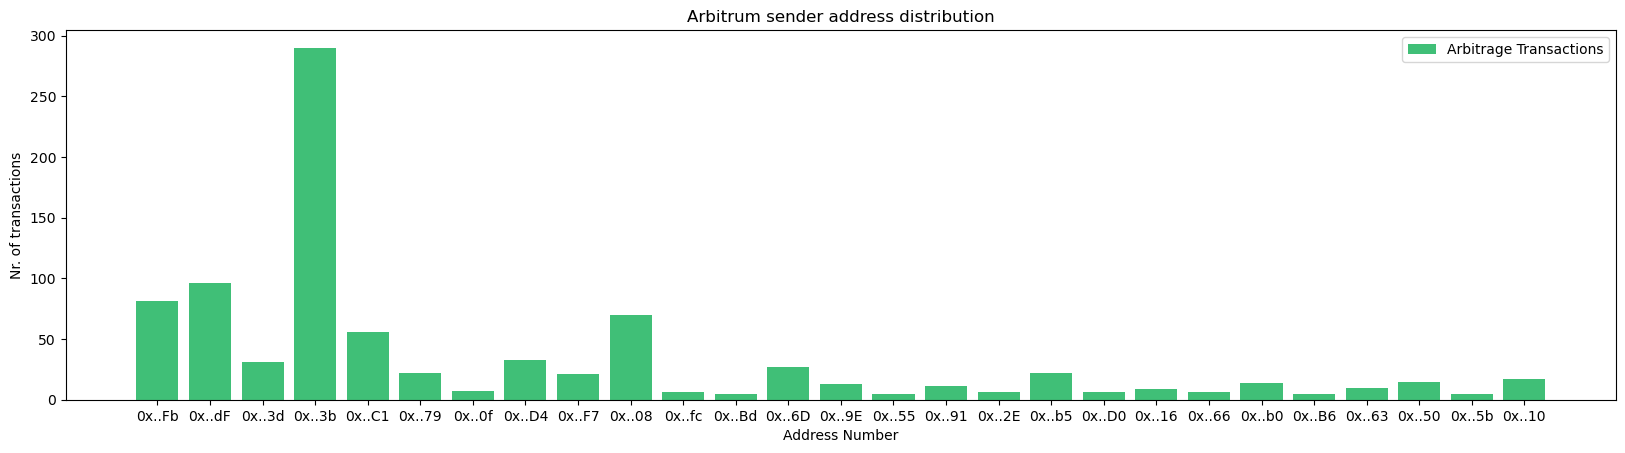

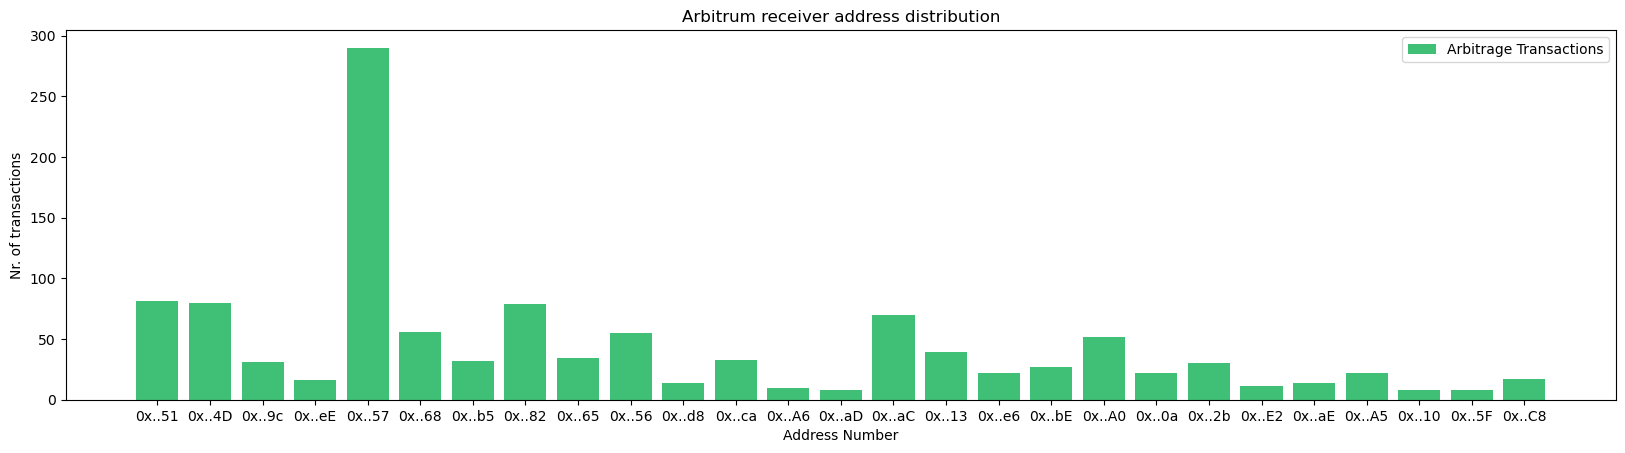

In [9]:
def plot_address_counts(reg_addresses, arbit_addresses, title, width):
    # reg_values, reg_counts = get_values_counts(reg_addresses)
    arbit_values, arbit_counts = get_values_counts(arbit_addresses)

    # Combine the values and counts while removing duplicates and adding 0s where neccessary
    # values, reg_counts, arbit_counts = combine_values_and_counts(reg_counts, reg_values, arbit_counts, arbit_values)
    values, arbit_counts = filter_values_and_counts2(arbit_values, arbit_counts, 5)
    
    values = [value[:2] + '..' + value[-2:] for value in values]
    

    figure, axes = plt.subplots()
    figure.set_figwidth(20)

    indexes = np.arange(len(values))
    # axes.bar(indexes - (width / 2), reg_counts, color='#e54624', width=width, label='Regular Transactions')
    axes.bar(values, arbit_counts, color='#40bf77', label='Arbitrage Transactions')
    
    axes.set_xlabel('Address Number')
    axes.set_ylabel('Nr. of transactions')
    axes.set_title(title)

    plt.legend()
    plt.show()

def combine_values_and_counts(counts1, values1, counts2, values2):
    values = []
    [values.append(value) for value in values1 if value not in values]
    [values.append(value) for value in values2 if value not in values]
    
    new_counts1, new_counts2 = [], []
    for value in values:
        if value in values1:
            value1_count = counts1[values1.index(value)]
        else:
            value1_count = 0

        if value in values2:
            value2_count = counts2[values2.index(value)]
        else:
            value2_count = 0

        new_counts1.append(value1_count)
        new_counts2.append(value2_count)

    return values, new_counts1, new_counts2

def filter_values_and_counts(values, reg_counts, arbit_counts, threshold):
    new_values, new_reg_counts, new_arbit_counts = [], [], []
    for index in range(len(values)):
        new_value = values[index]
        reg_count = reg_counts[index]
        arbit_count = arbit_counts[index]

        if reg_count >= threshold or arbit_count >= threshold:
            new_values.append(new_value)
            new_reg_counts.append(reg_count)
            new_arbit_counts.append(arbit_count)

    return new_values, new_reg_counts, new_arbit_counts

def filter_values_and_counts2(values, arbit_counts, threshold):
    top30 = sorted(arbit_counts, reverse=True)[:30]
    
    new_values, new_arbit_counts = [], []
    for index in range(len(values)):
        new_value = values[index]
        arbit_count = arbit_counts[index]

        if new_value == None:
            continue

        if arbit_count in top30 and len(new_values) != 30:
            new_values.append(new_value)
            new_arbit_counts.append(arbit_count)

    return new_values, new_arbit_counts

plot_address_counts(reg_senders, arbit_senders, 'Arbitrum sender address distribution', 0.7)
plot_address_counts(reg_receivers, arbit_receivers, 'Arbitrum receiver address distribution', 0.5)